In [31]:
# Load the required libraries

import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('shots_data.csv')
df.target.value_counts()

4.0    559
5.0    509
2.0    475
1.0    461
0.0    447
3.0    411
Name: target, dtype: int64

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

start_column = 60
end_column = 132

X, y = df.iloc[:, start_column:end_column], df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC(kernel = 'linear', C=30)

model.fit(X_train, y_train)

SVC(C=30, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [54]:
import numpy as np

class SVM:
    def __init__(self, learning_rate=0.001, lambda_p=0.01, epochs=1000):
        self.lr = learning_rate
        self.lambda_p = lambda_p
        self.epochs = epochs
        self.w = None
        self.b = None

    def fit(self, X, y):
        samples_size, features_size = X.shape

        y_ = np.where(y <= 0, -1, 1) # Since 1 and -1 are two classes. If 0 or less, make it -1

        self.w = np.zeros(features_size)
        self.b = 0

        for i in range(self.epochs):
            for idx, x_i in enumerate(X):
                cond_gt_one = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if cond_gt_one:
                    self.w -= self.lr * (2 * self.lambda_p * self.w)
                else:
                    self.w -= self.lr * (
                        2 * self.lambda_p * self.w - np.dot(x_i, y_[idx])
                    )
                    self.b -= self.lr * y_[idx]
                    
            if i % 100 == 0: # Print hinge loss every 100 epochs
                cost = self.lambda_p * np.linalg.norm(self.w)**2 + 1 / samples_size * \
                    np.max(np.c_[np.zeros(samples_size), 1 - y_ * (np.dot(X, self.w) - self.b)])  # hinge loss function
                print(f"Iteration {i:<10} Loss: {cost}")

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx) # Since 1 and -1 are the two classes

In [55]:
X, y = datasets.make_blobs(
        n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40
    )
y = np.where(y == 0, -1, 1)

clf = SVM()
clf.fit(X, y)
# predictions = clf.predict(X)

print(clf.w, clf.b)

Iteration 0          Loss: 0.017047018022294854
Iteration 100        Loss: 0.004981997653295138
Iteration 200        Loss: 0.003966605301602134
Iteration 300        Loss: 0.0039722596650188305
Iteration 400        Loss: 0.003920514326931924
Iteration 500        Loss: 0.0038307880714175497
Iteration 600        Loss: 0.003842371775466463
Iteration 700        Loss: 0.0038567220543601496
Iteration 800        Loss: 0.0038141840314295855
Iteration 900        Loss: 0.003830867347838515
[0.58977016 0.17946483] -0.1520000000000001


In [33]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93        93
         1.0       0.93      0.91      0.92        92
         2.0       0.90      0.97      0.93        96
         3.0       0.91      0.94      0.92        82
         4.0       0.97      0.88      0.92       108
         5.0       0.90      0.91      0.91       102

    accuracy                           0.92       573
   macro avg       0.92      0.92      0.92       573
weighted avg       0.92      0.92      0.92       573



In [60]:
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils # For drawing keypoints
points = mpPose.PoseLandmark # For landmarks
shots_list = ['Cut Shot', 'Cover Drive', 'Straight Drive', 'Pull Shot', 'Leg Glance', 'Scoop']
for i in shots_list:
    print(i, end=' ')
def predict_shot(img):
    data = []
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = pose.process(imgRGB)
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        for p in landmarks:
            data = data + [p.x, p.y, p.z, p.visibility]
        result = model.predict([data[start_column:end_column]])[0]
        text = shots_list[int(result)]
        return text

Cut Shot Cover Drive Straight Drive Pull Shot Leg Glance Scoop 

In [58]:
cap = cv2.VideoCapture(0)

with mpPose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # OpenCV = BGR, Mediapipe, Matplotlib = RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Detecting in the image
        results = pose.process(image)
        # Converting back to BGR for text 
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        text = 'empty'
        try:
            text = predict_shot(image)
        except:
            pass
        
        cv2.putText(image, text, (250, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)
        
        # Render detections
        mpDraw.draw_landmarks(image, results.pose_landmarks, mpPose.POSE_CONNECTIONS,
                                mpDraw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mpDraw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Video', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [54]:
cap.release()

In [ ]:
# Tflite object detection

In [1]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
from tflite_support import metadata
import tensorflow as tf

In [2]:
#@title Load the trained TFLite model and define some visualization functions

#@markdown This code comes from the TFLite Object Detection [Raspberry Pi sample](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

import platform
from typing import List, NamedTuple
import json

import cv2

Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 2
_FONT_THICKNESS = 2
_TEXT_COLOR = (0, 255, 0) #(45, 20, 122)  # BGR 


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

[Detection(bounding_box=Rect(left=130, top=8, right=481, bottom=154), categories=[Category(label='bat', score=0.81640625, index=0)])]


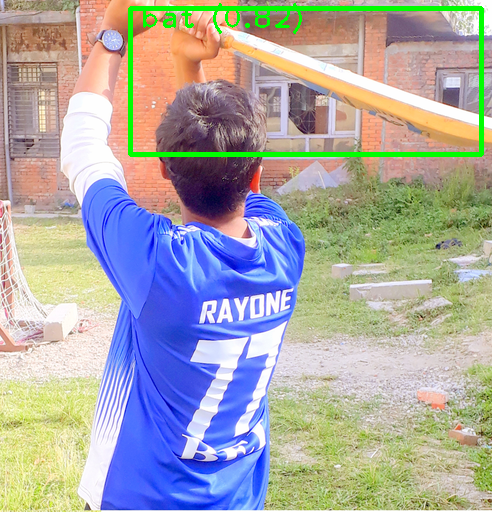

In [3]:
# Using image

from PIL import Image

# INPUT_IMAGE_URL = "C:\\Users\\D3LL-PC\\Desktop\\bat1.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.5 #@param {type:"number"}
TFLITE_MODEL_PATH = "G:\\MINOR\\MINOR PART 2\\Bat Detection\\bat_100.tflite" #@param {type:"string"}

#TEMP_FILE = 'C:\\Users\\D3LL-PC\\Documents\\image.jpg'
TEMP_FILE = 'C:\\Users\\D3LL-PC\\Desktop\\testing images\\bat2.jpg'
#!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
image = Image.open(TEMP_FILE).convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)
print(detections)
# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)

In [4]:
# # Using video (very slow)
# # video_path = 'G:\\MINOR\\MINOR PART 2\\Videos\\2.mp4'

# DETECTION_THRESHOLD = 0.5 
# TFLITE_MODEL_PATH = "G:\\MINOR\\MINOR PART 2\\Bat Detection\\bat_100.tflite" 

# cap = cv2.VideoCapture(video_path)

# while cap.isOpened():
#     ret, frame = cap.read()
#     if ret==True:
        
#         image_np = np.asarray(frame)
        
#         options = ObjectDetectorOptions(
#                   num_threads=4,
#                   score_threshold=DETECTION_THRESHOLD)
#         detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)

#         # Run object detection estimation using the model.
#         detections = detector.detect(image_np)
#         # Draw keypoints and edges on input image
#         image_np = visualize(image_np, detections)

#         # Show the detection result
#         #Image.fromarray(image_np)
#         cv2.imshow('Clip', image_np)
        
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()